In [ ]:
!pip uninstall -y flwr
!pip install flwr==1.23.0

# !pip install -q flwr[simulation]
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install kaggle

Found existing installation: flwr 1.4.0
Uninstalling flwr-1.4.0:
  Successfully uninstalled flwr-1.4.0
  Using cached flwr-1.4.0-py3-none-any.whl.metadata (12 kB)
Using cached flwr-1.4.0-py3-none-any.whl (157 kB)


In [2]:
import os

os.environ["FLWR_SIMULATION_USE_RAY"] = "0"
os.environ["FLWR_LOGGING"] = "error"

import random
from typing import List
from collections import OrderedDict

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
import flwr as fl
# from flwr.common import Context
import cv2

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

# (ADJUSTMENTS) NOVAS BIBLIOTECAS:
from torchvision.models import ResNet18_Weights
import torch.nn.functional as F


/home/adrianovss/MO839A/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-20 20:44:48,241	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
print(fl.__version__)

1.4.0


# Configs

In [4]:
NUM_CLIENTS = 7
RANDOM_SEED = 42
BATCH_SIZE = 64
ROUNDS = 22
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 224 # Imagenet size (224x224)
TEST_SIZE = 0.15
VALID_SIZE = 0.15
DATA_TRANSFORM = {
    "img_size": IMG_SIZE,
    "normalizer": { # Normalizer for Imagenet
        "mean":[0.485, 0.456, 0.406],
        "std":[0.229, 0.224, 0.225]
    }
}

MODEL_CONFIG = {
    "epochs": 3,
    "batch_size": 64,
    "learning_rate": 0.001,
    'criterion': nn.CrossEntropyLoss(),
    'optimizer': torch.optim.Adam,
    'patience': 3
}

In [5]:
# (ADJUSTMENTS) REMOVENDO AS CONFIGURAÇÕES DO GOOGLE DRIVE, PARA EXECUÇÃO LOCAL.
'''
    from google.colab import drive
    drive.mount('/content/drive')

    os.chdir("/content/drive/MyDrive/MO839-FL")
'''

'\n    from google.colab import drive\n    drive.mount(\'/content/drive\')\n\n    os.chdir("/content/drive/MyDrive/MO839-FL")\n'

In [6]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Dataset

In [7]:
kidney_dataset = pd.read_csv('./data/kidneyData.csv')
kidney_dataset

,image_id,path,diag,target,Class,group
0,Tumor- (1044),./data/Grouped images/Tumor/Group 10/Tumor- (1...,Tumor,3,Tumor,Tumor Group 10
1,Tumor- (83),./data/Grouped images/Tumor/Group 0/Tumor- (83...,Tumor,3,Tumor,Tumor Group 0
2,Tumor- (580),./data/Grouped images/Tumor/Group 5/Tumor- (58...,Tumor,3,Tumor,Tumor Group 5
3,Tumor- (1701),./data/Grouped images/Tumor/Group 17/Tumor- (1...,Tumor,3,Tumor,Tumor Group 17
4,Tumor- (1220),./data/Grouped images/Tumor/Group 13/Tumor- (1...,Tumor,3,Tumor,Tumor Group 13
...,...,...,...,...,...,...
12436,Cyst- (2522),./data/Grouped images/Cyst/Group 50/Cyst- (252...,Cyst,0,Cyst,Cyst Group 50
12437,Cyst- (2627),./data/Grouped images/Cyst/Group 51/Cyst- (262...,Cyst,0,Cyst,Cyst Group 51
12438,Cyst- (972),./data/Grouped images/Cyst/Group 26/Cyst- (972...,Cyst,0,Cyst,Cyst Group 26
12439,Cyst- (2323),./data/Grouped images/Cyst/Group 45/Cyst- (232...,Cyst,0,Cyst,Cyst Group 45


In [8]:
LABELS = sorted(kidney_dataset['Class'].unique())
LABEL2TARGET = {str(l): i for i, l in enumerate(LABELS)}
NUM_CLASSES = len(LABELS)

In [9]:
LABEL2TARGET

{'Cyst': 0, 'Normal': 1, 'Stone': 2, 'Tumor': 3}

In [10]:
# Focal Loss:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(kidney_dataset["Class"]),
    y=kidney_dataset["Class"]
)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)


MODEL_CONFIG['criterion'] = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)

In [11]:
class KidneyData(Dataset):
    def __init__(self, metadata: pd.DataFrame, label_map: dict, transform=None):
        self.metadata = metadata.reset_index(drop=True)
        self.transform = transform
        self.label_map = label_map

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        img_path = row['path']
        label_str = str(row['Class'])
        label = int(self.label_map[label_str])
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)


image Tumor format (512, 512, 3)
image Normal format (512, 512, 3)
image Stone format (512, 512, 3)
image Cyst format (545, 675, 3)


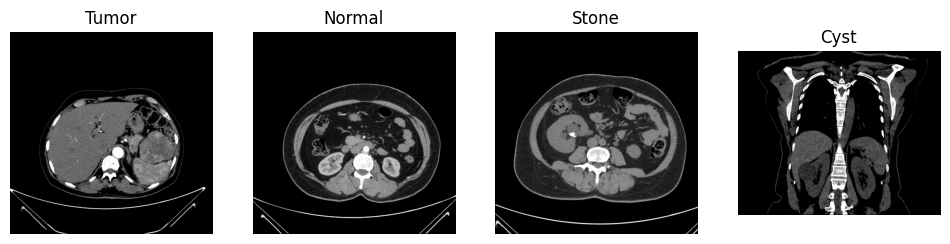

In [12]:
classes = kidney_dataset['Class'].unique()

fig, ax = plt.subplots(1, len(classes), figsize=(12, 12))
for i, c in enumerate(classes):
    class_df = kidney_dataset[kidney_dataset['Class'] == c]
    random_integer = random.randint(1, 10)
    data = KidneyData(class_df, label_map=LABEL2TARGET)
    img, label = data.__getitem__(random.randint(1, len(class_df)))
    print(f"image {c} format {np.array(img).shape}")
    img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)
    plt.subplot(1, len(classes), i+1)
    plt.imshow(img)
    plt.title(c)
    plt.axis('off')
plt.show()

## Splitting data

### Separating some data for testing global model and get clients data

Clients groups: 179
Test groups: 38
Intersection: set()


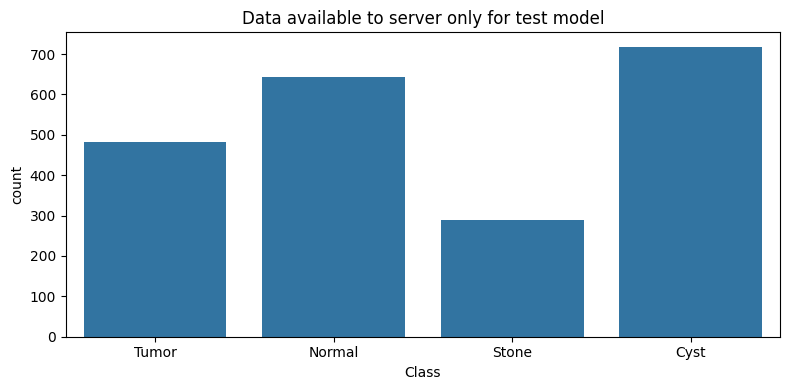

In [13]:
# Preserving classes distribution on test set
splitter = StratifiedGroupKFold(n_splits=int(1/TEST_SIZE), shuffle=True, random_state=RANDOM_SEED)
clients_idx, test_idx = next(splitter.split(
    kidney_dataset,
    kidney_dataset["Class"],
    groups=kidney_dataset["group"]
    )
)

clients_df = kidney_dataset.iloc[clients_idx].reset_index(drop=True)
test_df  = kidney_dataset.iloc[test_idx].reset_index(drop=True)


print("Clients groups:", clients_df["group"].nunique())
print("Test groups:", test_df["group"].nunique())
print("Intersection:", set(clients_df["group"]) & set(test_df["group"]))

plt.figure(figsize=(8, 4))

sns.countplot(x=test_df['Class'])
plt.title("Data available to server only for test model")

plt.tight_layout()
plt.show()

### Get clients (not available data for server)

In [14]:
def split_on_clients(clients_df: pd.DataFrame, num_clients: int = NUM_CLIENTS, val_frac: float = VALID_SIZE):
    """
    Splits data in NUM_CLIENTS clients, randomly, splitting in train and validation data inside each client (like small datasets)

    """
    unique_groups = clients_df["group"].unique()
    np.random.seed(42)
    np.random.shuffle(unique_groups)
    group_splits = np.array_split(unique_groups, num_clients)

    clients = {}

    for i, split in enumerate(group_splits):
        client_df = clients_df[clients_df["group"].isin(split)]
        splitter = GroupShuffleSplit(n_splits=1, test_size = val_frac, random_state=RANDOM_SEED)
        train_idx, val_idx = next(splitter.split(client_df, client_df["Class"], groups=client_df["group"]))

        client_train_df = client_df.iloc[train_idx].reset_index(drop=True)
        client_val_df = client_df.iloc[val_idx].reset_index(drop=True)

        clients[i] = {'train': client_train_df, 'valid': client_val_df}

    return clients

# def split_on_clients(clients_df, num_clients=NUM_CLIENTS, val_frac=VALID_SIZE):
#     groups = list(clients_df["group"].unique())
#     groups.sort()

#     # calcula tamanho de cada grupo
#     group_sizes = {g: len(clients_df[clients_df["group"] == g]) for g in groups}

#     # ordena grupos do maior para menor
#     groups_sorted = sorted(groups, key=lambda g: group_sizes[g], reverse=True)

#     # distribui grupos balanceando o total de imagens por cliente
#     client_buckets = [[] for _ in range(num_clients)]
#     bucket_sizes = [0] * num_clients

#     for g in groups_sorted:
#         smallest = bucket_sizes.index(min(bucket_sizes))
#         client_buckets[smallest].append(g)
#         bucket_sizes[smallest] += group_sizes[g]

#     clients = {}
#     for cid in range(num_clients):
#         cid_df = clients_df[clients_df["group"].isin(client_buckets[cid])]

#         splitter = GroupShuffleSplit(n_splits=1, test_size=val_frac, random_state=RANDOM_SEED)
#         train_idx, val_idx = next(splitter.split(cid_df, cid_df["Class"], groups=cid_df["group"]))

#         clients[cid] = {
#             "train": cid_df.iloc[train_idx].reset_index(drop=True),
#             "valid": cid_df.iloc[val_idx].reset_index(drop=True)
#         }

#     return clients


In [15]:
# (ADJUSTMENTS)
def split_on_non_iid_clients(clients_df: pd.DataFrame,
                             num_clients: int = NUM_CLIENTS,
                             val_frac: float = VALID_SIZE,
                             alpha: float = 0.5):
    """
    Non-IID usando distribuição Dirichlet.
    - Garante todas as classes em todos os clientes
    - Mantém heterogeneidade controlada
    - Evita clientes com classes faltando
    """
    
    np.random.seed(42)
    clients = {}

    # Converte labels para numpy
    labels = clients_df["Class"].values
    unique_classes = np.unique(labels)

    # Índices do dataframe completo
    all_indices = np.arange(len(clients_df))

    # Lista de índices para cada cliente
    client_indices = [[] for _ in range(num_clients)]

    # Para cada classe, divide seus índices entre os clientes
    for cls in unique_classes:
        cls_idx = all_indices[labels == cls]

        # distribuição Dirichlet (controla Non-IID)
        proportions = np.random.dirichlet(alpha=[alpha] * num_clients)
        proportions = (proportions * len(cls_idx)).astype(int)

        start = 0
        for cid, amount in enumerate(proportions):
            client_indices[cid].extend(cls_idx[start:start + amount])
            start += amount

    # Embaralha
    for cid in range(num_clients):
        np.random.shuffle(client_indices[cid])

        cid_df = clients_df.iloc[client_indices[cid]].reset_index(drop=True)

        # split train/validation por cliente
        splitter = GroupShuffleSplit(n_splits=1, test_size=val_frac, random_state=42)
        train_idx, val_idx = next(splitter.split(cid_df, cid_df["Class"], groups=cid_df["group"]))

        client_train_df = cid_df.iloc[train_idx].reset_index(drop=True)
        client_val_df = cid_df.iloc[val_idx].reset_index(drop=True)

        clients[cid] = {'train': client_train_df, 'valid': client_val_df}

    return clients


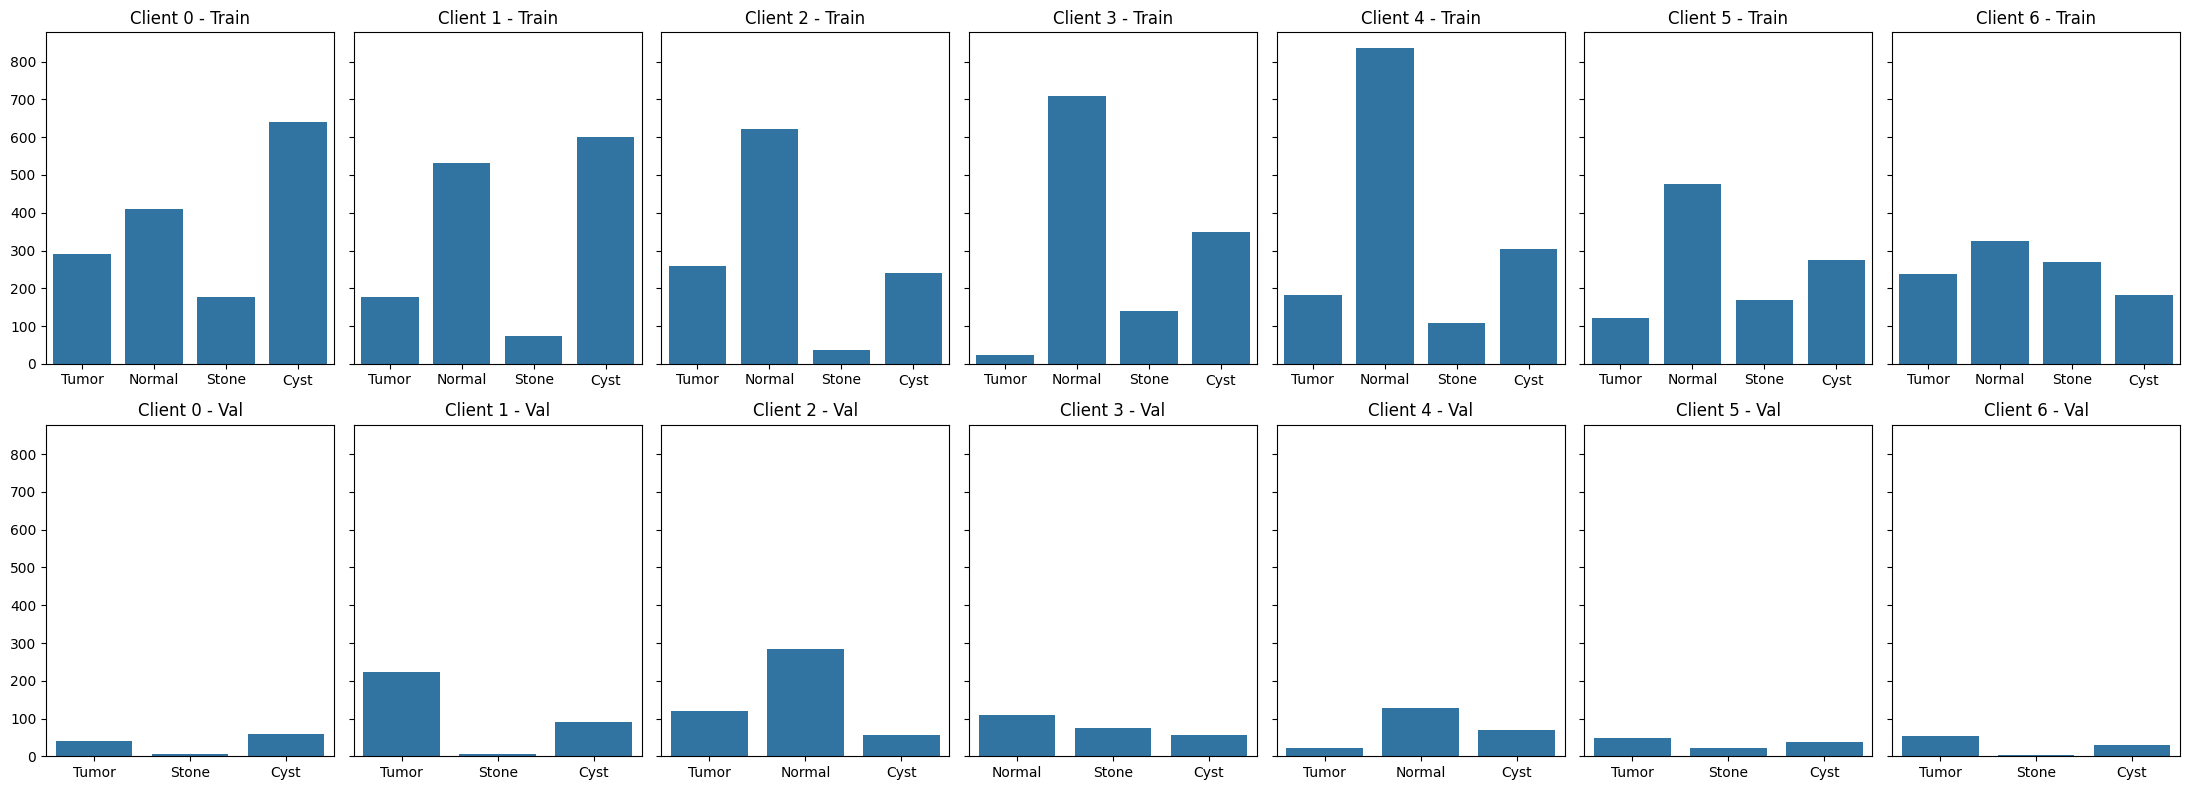

In [16]:
random_clients = split_on_clients(clients_df, NUM_CLIENTS, VALID_SIZE)

fig, axes = plt.subplots(2, NUM_CLIENTS, figsize=(22, 8), sharey=True)
axes = axes.flatten()

for i, (client_id, data) in enumerate(random_clients.items()):
    # Plot Train
    sns.countplot(x=data["train"]["Class"], ax=axes[i])
    axes[i].set_title(f"Client {client_id} - Train")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

    # Plot Validation
    sns.countplot(x=data["valid"]["Class"], ax=axes[i + NUM_CLIENTS])
    axes[i + NUM_CLIENTS].set_title(f"Client {client_id} - Val")
    axes[i + NUM_CLIENTS].set_xlabel("")
    axes[i + NUM_CLIENTS].set_ylabel("")

plt.tight_layout()
plt.show()

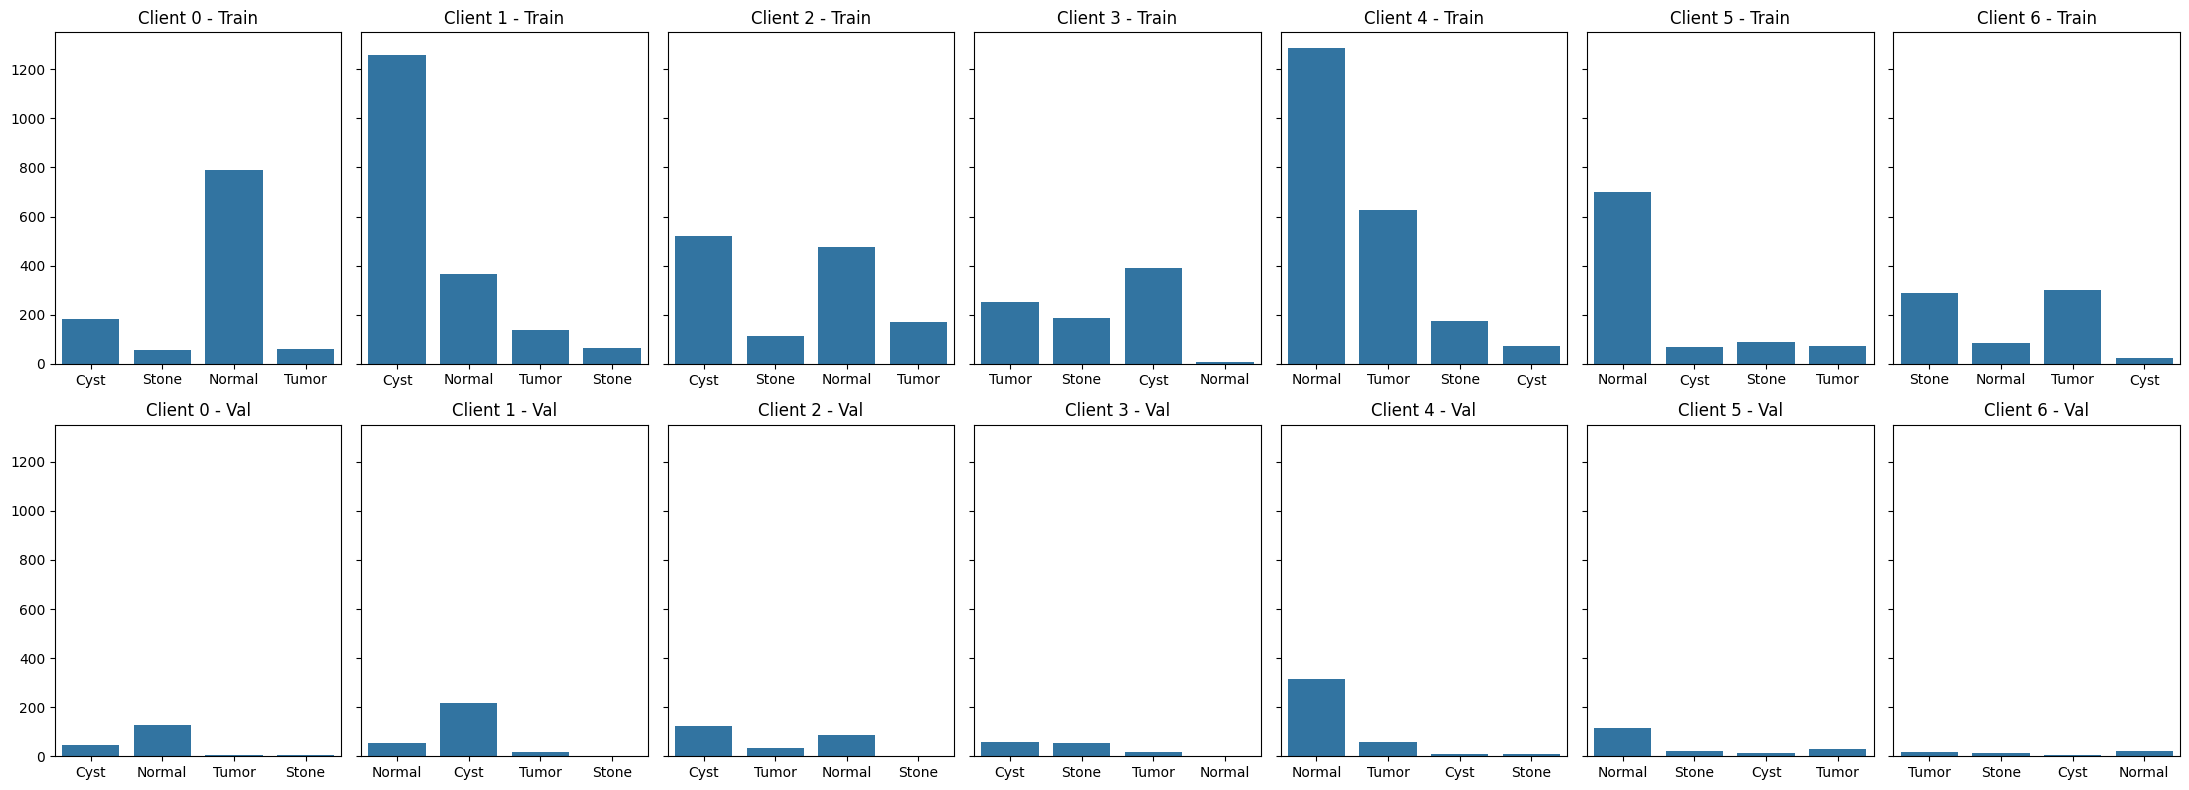

In [17]:
non_iid_clients = split_on_non_iid_clients(clients_df, NUM_CLIENTS, VALID_SIZE, alpha=1.0)

fig, axes = plt.subplots(2, NUM_CLIENTS, figsize=(22, 8), sharey=True)
axes = axes.flatten()

for i, (client_id, data) in enumerate(non_iid_clients.items()):
    # Plot Train
    sns.countplot(x=data["train"]["Class"], ax=axes[i])
    axes[i].set_title(f"Client {client_id} - Train")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

    # Plot Validation
    sns.countplot(x=data["valid"]["Class"], ax=axes[i + NUM_CLIENTS])
    axes[i + NUM_CLIENTS].set_title(f"Client {client_id} - Val")
    axes[i + NUM_CLIENTS].set_xlabel("")
    axes[i + NUM_CLIENTS].set_ylabel("")

plt.tight_layout()
plt.show()

## Loading data

In [18]:
# (ADJUSTMENTS) 
'''
    Altera a configuração da variável `transform`, para:
    - Reduzir o overfitting local
    - Melhorar a generalização
    - Seguir os padrões do ResNet Pré-Treinado
'''


def load_datasets(
    clients: dict,
    test_df: pd.DataFrame,
    transforms_config: dict,
    batch_size: int = 32,
    label_map = dict
):
    img_size = transforms_config['img_size']
    normalize_config = transforms_config['normalizer']
    # transform = transforms.Compose([
    #     transforms.Resize((224, 224)),
    #     transforms.RandomHorizontalFlip(),
    #     transforms.RandomRotation(10),
    #     transforms.ColorJitter(
    #         brightness=0.2,
    #         contrast=0.2,
    #         saturation=0.2,
    #         hue=0.02
    #     ),
    #     transforms.RandomAdjustSharpness(sharpness_factor=1.5, p=0.3),
    #     transforms.ToTensor(),
    #     transforms.Normalize(
    #         [0.485, 0.456, 0.406],
    #         [0.229, 0.224, 0.225]
    #     ),
    # ])
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(8),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]
        ),
    ])
        
    trainloaders = []
    valloaders = []

    for client_id, data in clients.items():
        train_dataset = KidneyData(data["train"], label_map, transform)
        val_dataset = KidneyData(data["valid"], label_map, transform)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

        trainloaders.append(train_loader)
        valloaders.append(val_loader)

    test_dataset = KidneyData(test_df, label_map, transform)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    return trainloaders, valloaders, testloader

In [19]:
########## 
random_clients = split_on_clients(clients_df, NUM_CLIENTS, VALID_SIZE)

trainloaders, valloaders, testloader = load_datasets(
    clients=non_iid_clients,
    test_df=test_df,
    transforms_config = DATA_TRANSFORM,
    batch_size = BATCH_SIZE,
    label_map=LABEL2TARGET
)

# Model

In [20]:
import copy

def train(model,
          trainloader,
          valloader,
          device,
          patience,
          global_params=None,
          mu=0.01,
          verbose=False):

    epochs = MODEL_CONFIG['epochs']
    criterion = MODEL_CONFIG['criterion']
    optimizer_class = MODEL_CONFIG['optimizer']
    lr = MODEL_CONFIG['learning_rate']

    # Weight decay + only trainable params
    optimizer = optimizer_class(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr,
        weight_decay=1e-4
    )

    # Scheduler para estabilizar FL
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size=2,
        gamma=0.5
    )

    model.to(device)

    best_val_loss = float("inf")
    epochs_no_improve = 0
    best_state_dict = None

    for epoch in range(epochs):

        model.train()
        correct, total = 0, 0
        epoch_loss = 0.0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            # -----------------------------------
            # FEDPROX — TERMO PROXIMAL REAL
            # -----------------------------------
            if global_params is not None:
                prox = 0.0
                for w, w_global in zip(model.parameters(), global_params):
                    prox += ((w - w_global.to(device)) ** 2).sum()
                loss = loss + (mu / 2) * prox
            # -----------------------------------

            loss.backward()

            # Clipping para estabilizar FL
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)

            optimizer.step()

            epoch_loss += loss.item() * images.size(0)
            total += labels.size(0)
            correct += (torch.argmax(outputs, dim=1) == labels).sum().item()

        # Final do epoch
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total if total > 0 else 0.0

        # Step do scheduler
        scheduler.step()

        # Avaliação no cliente
        val_metrics, _ = evaluate(model, valloader, device, num_classes=NUM_CLASSES)
        val_loss = val_metrics['loss']

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_state_dict = copy.deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                if verbose:
                    print(f"Early stopping at epoch {epoch+1}")
                break

        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss:.4f}, acc {epoch_acc:.4f}, val_loss {val_loss:.4f}")

    # Retorna o melhor estado
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

    return model



def evaluate(model, testloader, device, num_classes):
    model.to(device)
    criterion = MODEL_CONFIG['criterion']
    model.eval()

    total, correct = 0, 0
    running_loss = 0.0

    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device, dtype=torch.long)

            outputs = model(images)
            loss = criterion(outputs, labels)

            # loss ponderado pelo tamanho do batch
            running_loss += loss.item() * labels.size(0)

            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.append(probs.cpu().numpy())

    # loss médio real
    loss = running_loss / total if total > 0 else 0.0
    accuracy = correct / total if total > 0 else 0.0

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.concatenate(y_prob, axis=0)

    # AUC CORRIGIDO
    try:
        if num_classes == 2:
            auc = roc_auc_score(y_true, y_prob[:, 1])
        else:
            auc = roc_auc_score(y_true, y_prob, multi_class='ovr')
    except Exception:
        auc = float('nan')

    return {
        'loss': float(loss),
        'accuracy': float(accuracy),
        'precision': float(precision_score(y_true, y_pred, average='weighted', zero_division=0)),
        'recall':  float(recall_score(y_true, y_pred, average='weighted', zero_division=0)),
        'f1-score': float(f1_score(y_true, y_pred, average='weighted', zero_division=0)),
        'auc': auc
    }, confusion_matrix(y_true, y_pred)



def get_parameters(model: nn.Module) -> List[np.ndarray]:
    return [val.detach().cpu().numpy() for _, val in model.state_dict().items()]

def set_parameters(model: nn.Module, parameters: List[np.ndarray]):
    state_dict_keys = list(model.state_dict().keys())
    new_state = OrderedDict()
    for k, arr in zip(state_dict_keys, parameters):
        ref = model.state_dict()[k]
        t = torch.tensor(arr, dtype=ref.dtype, device=ref.device)
        new_state[k] = t
    model.load_state_dict(new_state, strict=True)

## ResNet18

- Here a ResNet18, pretrained with Imagenet dataset will be used, freezing net parameter and fine tuning final layer parameters (transfer learning)

In [21]:
# original model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
# (ADJUSTMENTS) 
'''
    Pretrained ImageNet melhora MUITO classes difíceis (“Stone” e “Tumor”)
    Libera o  `layer4` permitindo o Federated Learning aprender padrões específicos do dataset renal
'''

# def build_model(num_classes):
#     with torch.device("cpu"):
#         model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

#         # Congela tudo
#         for name, param in model.named_parameters():
#             param.requires_grad = False

#         # Descongela só o final da rede
#         for name, param in model.layer4.named_parameters():
#             param.requires_grad = True

#         model.fc = nn.Sequential(
#             nn.Linear(model.fc.in_features, 128),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(128, num_classes)
#         )

#     return model.cpu()

# def build_model(num_classes):
#     model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

#     # Congela tudo
#     for name, param in model.named_parameters():
#         param.requires_grad = False

#     # Descongela só o final da rede
#     for name, param in model.layer4.named_parameters():
#         param.requires_grad = True

#     model.fc = nn.Sequential(
#         nn.Linear(model.fc.in_features, 128),
#         nn.ReLU(),
#         nn.Dropout(0.2),
#         nn.Linear(128, num_classes)
#     )
#     return model

# from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# def build_model(num_classes):
#     model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

#     # Congela tudo exceto classifier
#     for name, param in model.named_parameters():
#         param.requires_grad = False

#     model.classifier[1] = nn.Sequential(
#         nn.Dropout(0.3),
#         nn.Linear(model.classifier[1].in_features, 256),
#         nn.ReLU(),
#         nn.Linear(256, num_classes)
#     )

#     return model

# from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

# def build_model(num_classes):
#     model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)

#     # congela tudo exceto classifier
#     for name, param in model.named_parameters():
#         if "classifier" not in name:
#             param.requires_grad = False

#     model.classifier = nn.Sequential(
#         nn.Linear(model.classifier[0].in_features, 256),
#         nn.ReLU(),
#         nn.Dropout(0.2),
#         nn.Linear(256, num_classes)
#     )
#     return model

# def build_model(num_classes):
#     model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

#     # CONGELA TUDO MENOS layer4
#     for name, param in model.named_parameters():
#         if not (("layer4" in name) or ("layer3" in name)):
#             param.requires_grad = False

#     model.fc = nn.Sequential(
#         nn.Linear(model.fc.in_features, 256),
#         nn.ReLU(),
#         nn.Dropout(0.3),
#         nn.Linear(256, num_classes)
#     )
#     return model

def build_model(num_classes):
    model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

    for name, param in model.named_parameters():
        param.requires_grad = False   # <-- congela TUDO

    # só treina a última camada
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


- Adapted model

In [23]:
model = build_model(num_classes = NUM_CLASSES)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
# Check trainable and not trainable layers
trainable_layers = []
frozen_layers = []

for name, param in model.named_parameters():
    if param.requires_grad:
        trainable_layers.append(name)
    else:
        frozen_layers.append(name)

print("Trainable layers:")
for name in trainable_layers:
    print(name)

print("\nFrozen layers:")
for name in frozen_layers:
    print(name)

Trainable layers:
fc.weight
fc.bias

Frozen layers:
conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
lay

# Flower and Federated Learning

## Client

In [25]:
# (ADJUSTMENTS)
BASE_MODEL = build_model(NUM_CLASSES)
BASE_MODEL = BASE_MODEL.to("cpu")             # <-- IMPORTANTE
BASE_STATE = {k: v.cpu() for k, v in BASE_MODEL.state_dict().items()}

class KidneyClient(fl.client.NumPyClient):
    def __init__(
        self,
        model,
        trainloader,
        valloader,
        device,
        num_classes
    ):
        self.model = model
        self.trainloader = trainloader
        self.valloader = valloader
        self.device = device
        self.num_classes = num_classes

    # --------------------------------------------------------
    # RETORNA OS PARÂMETROS LOCAIS
    # --------------------------------------------------------
    def get_parameters(self, config):
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    # --------------------------------------------------------
    # RECEBE OS PESOS DO MODELO GLOBAL (VENDA DO SERVIDOR)
    # --------------------------------------------------------
    def set_parameters(self, parameters):
        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        self.model.load_state_dict(state_dict, strict=True)

    # --------------------------------------------------------
    # FIT — AGORA COM FEDPROX
    # --------------------------------------------------------
    def fit(self, parameters, config):
        # 1. RECEBE PESOS GLOBAIS
        self.set_parameters(parameters)
        self.model.to(self.device)

        # 2. SALVA PESOS GLOBAIS PARA O FEDPROX
        global_params = [p.clone().detach() for p in self.model.parameters()]

        # 3. TREINAMENTO LOCAL
        trained_model = train(
            model=self.model,
            trainloader=self.trainloader,
            valloader=self.valloader,
            device=self.device,
            patience=2,
            global_params=global_params,   # <--
            mu=0.1,               # <--
            verbose=False
        )
        # 4. RETORNA OS PESOS LOCAIS APÓS O TREINO
        return (
            [val.cpu().numpy() for _, val in trained_model.state_dict().items()],
            len(self.trainloader.dataset),
            {}
        )

    # --------------------------------------------------------
    # EVALUATE (sem mudanças)
    # --------------------------------------------------------
    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        self.model.to(self.device)

        metrics, _ = evaluate(self.model, self.valloader, self.device, num_classes=self.num_classes)
        return float(metrics["loss"]), len(self.valloader.dataset), metrics

    # def evaluate(self, parameters, config):
    #     self.set_parameters(parameters)
    #     self.model.to(self.device)

    #     # Avaliação no TRAIN e não no VAL
    #     metrics, _ = evaluate(
    #         self.model, 
    #         self.trainloader, 
    #         self.device,
    #         num_classes=self.num_classes
    #     )

    #     return float(metrics["loss"]), len(self.trainloader.dataset), metrics




def client_fn(cid: str):
    """Create a Kidney client representing a single organization."""

    model = build_model(num_classes=NUM_CLASSES)
    model = model.to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # return KidneyClient(model, trainloader, valloader, DEVICE, NUM_CLASSES).to_client()
    return KidneyClient(model, trainloader, valloader, DEVICE, NUM_CLASSES)


# def client_fn(cid: str):

#     # 1) Cria modelo SEM MOVER PARA GPU
#     model = build_model(num_classes=NUM_CLASSES)
    
#     # 2) NÃO FAÇA model.to(DEVICE) AQUI
#     # Flower vai pegar os pesos no CPU

#     trainloader = trainloaders[int(cid)]
#     valloader = valloaders[int(cid)]

#     return KidneyClient(
#         model=model,
#         trainloader=trainloader,
#         valloader=valloader,
#         device=DEVICE,          # a GPU só será usada dentro do fit()
#         num_classes=NUM_CLASSES
#     )


# def client_fn(cid: str):
#     model = build_model(NUM_CLASSES)

#     # Carrega PESOS DO CPU SEMPRE
#     model.load_state_dict(BASE_STATE)

#     trainloader = trainloaders[int(cid)]
#     valloader = valloaders[int(cid)]

#     return KidneyClient(
#         model=model,
#         trainloader=trainloader,
#         valloader=valloader,
#         device=DEVICE,
#         num_classes=NUM_CLASSES
#     )

## Server

In [26]:
def server_evaluate_fn(save_path: str = '.'):
    def evaluate_fn(server_round: int, parameters, config):
        model = build_model(NUM_CLASSES)

        set_parameters(model, parameters)
        metrics, cm = evaluate(model, testloader, DEVICE, NUM_CLASSES)
        loss = float(metrics['loss'])

        os.makedirs(save_path, exist_ok=True)

        if server_round != 0:
            torch.save(model.state_dict(), f"{save_path}/model_round{server_round}.pt")

        return loss, metrics

    return evaluate_fn

### Aggregation strategy

- FedAvg, FedAvg, FedAdagrad, FedAdam, FedYogi, Krum, DPFedAvgAdaptive, QFedAvg, FaultTolerantFedAvg

In [ ]:
# (ADJUSTMENTS)
def metrics_agg(metrics):
    # metrics = [(num_examples, {"loss": ..., "accuracy": ...}), ...]
    total_examples = sum(num for num, _ in metrics)
    aggregated = {}
    for key in metrics[0][1].keys():
        aggregated[key] = sum(num * m[key] for num, m in metrics) / total_examples
    return aggregated


# -----------------------------------------------------------------
# CONFIGURAÇÕES ENVIADAS AOS CLIENTES (FedProx precisa disso)
# -----------------------------------------------------------------
def fit_config(server_round: int):
    return {
        "round": server_round,
        "local_epochs": MODEL_CONFIG["epochs"],
    }

def eval_config(server_round: int):
    return {
        "round": server_round
    }


from flwr.server.strategy import FedProx, FedAvg, FedAdagrad, FedAdam, FedYogi, Krum, DPFedAvgAdaptive, QFedAvg, FaultTolerantFedAvg
import flwr as fl

# -----------------------------------------------------------------
# ESTRATÉGIA FEDPROX FINAL (COMPLETA + CORRIGIDA)
# -----------------------------------------------------------------
strategy = FedProx(
    fraction_fit=1.0,
    fraction_evaluate=1.0,
    min_fit_clients=NUM_CLIENTS,
    min_evaluate_clients=NUM_CLIENTS,
    min_available_clients=NUM_CLIENTS,
    proximal_mu=0.05,
    evaluate_fn=server_evaluate_fn(save_path='models_25_rounds'),
    evaluate_metrics_aggregation_fn=metrics_agg
)

# strategy = FedAvg(
#     fraction_fit=1.0,
#     fraction_evaluate=1.0,
#     min_fit_clients=NUM_CLIENTS,
#     min_evaluate_clients=NUM_CLIENTS,
#     min_available_clients=NUM_CLIENTS,
#     evaluate_fn=server_evaluate_fn(save_path='models_25_rounds'),
#     evaluate_metrics_aggregation_fn=metrics_agg,
# )

# strategy = FedAvg(
#     fraction_fit=1.0,
#     fraction_evaluate=1.0,
#     min_fit_clients=NUM_CLIENTS,
#     min_evaluate_clients=NUM_CLIENTS,
#     min_available_clients=NUM_CLIENTS,
#     evaluate_fn=server_evaluate_fn(save_path='models_25_rounds'),
#     evaluate_metrics_aggregation_fn=metrics_agg,
# )

# strategy = FedAdagrad(
#     fraction_fit=1.0,
#     fraction_evaluate=1.0,
#     min_fit_clients=NUM_CLIENTS,
#     min_evaluate_clients=NUM_CLIENTS,
#     min_available_clients=NUM_CLIENTS,
#     eta=0.1,
#     tau=1e-9,
#     evaluate_fn=server_evaluate_fn(save_path='models_22_rounds_fedadagrad'),
#     evaluate_metrics_aggregation_fn=metrics_agg
# )

# strategy = FedAdam(
#     fraction_fit=1.0,
#     fraction_evaluate=1.0,
#     min_fit_clients=NUM_CLIENTS,
#     min_evaluate_clients=NUM_CLIENTS,
#     min_available_clients=NUM_CLIENTS,
#     eta=0.001,         # taxa de aprendizado global
#     eta_l=0.001,       # taxa de aprendizado local
#     beta_1=0.9,
#     beta_2=0.99,
#     tau=1e-9,
#     evaluate_fn=server_evaluate_fn(save_path='models_22_rounds_fedadam'),
#     evaluate_metrics_aggregation_fn=metrics_agg,
# )

# strategy = FedYogi(
#     fraction_fit=1.0,
#     fraction_evaluate=1.0,
#     min_fit_clients=NUM_CLIENTS,
#     min_evaluate_clients=NUM_CLIENTS,
#     min_available_clients=NUM_CLIENTS,
#     eta=0.001,         # taxa de aprendizado global
#     eta_l=0.001,       # taxa de aprendizado local
#     beta_1=0.9,
#     beta_2=0.99,
#     tau=1e-9,
#     evaluate_fn=server_evaluate_fn(save_path='models_22_rounds_fedyogi'),
#     evaluate_metrics_aggregation_fn=metrics_agg,
# )

# strategy = Krum(
#     fraction_fit=1.0,
#     fraction_evaluate=1.0,
#     min_fit_clients=NUM_CLIENTS,
#     min_evaluate_clients=NUM_CLIENTS,
#     min_available_clients=NUM_CLIENTS,
#     krum_config={"multi_krum": False, "num_krum": 1},  # ajustar conforme necessário
#     evaluate_fn=server_evaluate_fn(save_path='models_22_rounds_krum'),
#     evaluate_metrics_aggregation_fn=metrics_agg,
# )

# strategy = DPFedAvgAdaptive(
#     fraction_fit=1.0,
#     fraction_evaluate=1.0,
#     min_fit_clients=NUM_CLIENTS,
#     min_evaluate_clients=NUM_CLIENTS,
#     min_available_clients=NUM_CLIENTS,
#     noise_multiplier=1.0,           # ajustar conforme necessário
#     l2_norm_clip=1.0,               # ajustar conforme necessário
#     adaptive_clip=True,             # ativa o clipping adaptativo
#     evaluate_fn=server_evaluate_fn(save_path='models_22_rounds_dp_fedavg_adaptive'),
#     evaluate_metrics_aggregation_fn=metrics_agg,
# )

# strategy = QFedAvg(
#     fraction_fit=1.0,
#     fraction_evaluate=1.0,
#     min_fit_clients=NUM_CLIENTS,
#     min_evaluate_clients=NUM_CLIENTS,
#     min_available_clients=NUM_CLIENTS,
#     q_param=0.5,  # ajustar conforme desejado
#     evaluate_fn=server_evaluate_fn(save_path='models_22_rounds_qfedavg'),
#     evaluate_metrics_aggregation_fn=metrics_agg,
# )

# strategy = FaultTolerantFedAvg(
#     fraction_fit=1.0,
#     fraction_evaluate=1.0,
#     min_fit_clients=NUM_CLIENTS,
#     min_evaluate_clients=NUM_CLIENTS,
#     min_available_clients=NUM_CLIENTS,
#     evaluate_fn=server_evaluate_fn(save_path='models_22_rounds_fault_toler_fedavg'),
#     evaluate_metrics_aggregation_fn=metrics_agg,
# )

## Simulation

In [28]:
print(f"running in {DEVICE}")

running in cuda


In [29]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce GTX 1650


In [30]:
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=ROUNDS),
    strategy=strategy,
    client_resources={
        "num_cpus": 1,
        "num_gpus": 0.25
    }
)


INFO flwr 2025-11-20 20:44:51,459 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=22, round_timeout=None)
2025-11-20 20:44:53,195	INFO worker.py:1771 -- Started a local Ray instance.
INFO flwr 2025-11-20 20:44:53,975 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:172.22.4.17': 1.0, 'CPU': 12.0, 'accelerator_type:G': 1.0, 'GPU': 1.0, 'object_store_memory': 3404422348.0, 'memory': 6808844699.0, 'node:__internal_head__': 1.0}
INFO flwr 2025-11-20 20:44:53,976 | server.py:86 | Initializing global parameters
INFO flwr 2025-11-20 20:44:53,976 | server.py:273 | Requesting initial parameters from one random client
INFO flwr 2025-11-20 20:44:57,518 | server.py:277 | Received initial parameters from one random client
INFO flwr 2025-11-20 20:44:57,518 | server.py:88 | Evaluating initial parameters
INFO flwr 2025-11-20 20:45:14,457 | server.py:91 | initial parameters (loss, other metrics): 1.533855682463362, {'loss': 1.533855682463362, 'accuracy': 0.22

### Show Federated learning history

In [31]:
print("All history: ", history)

All history:  History (loss, distributed):
	round 1: 1.3443025848950716
	round 2: 1.0242771644167858
	round 3: 0.9672151078505847
	round 4: 0.9085070291083163
	round 5: 0.8705225598546836
	round 6: 0.8626706086536235
	round 7: 0.8295924757592837
	round 8: 0.8049126282304184
	round 9: 0.7911176558933142
	round 10: 0.7644308341650728
	round 11: 0.7840633588872563
	round 12: 0.749819728223681
	round 13: 0.7359786637313287
	round 14: 0.7271962669839428
	round 15: 0.6855884969274658
	round 16: 0.7268163294946512
	round 17: 0.7218932978060305
	round 18: 0.7065289470286121
	round 19: 0.6868587312711225
	round 20: 0.7086753003193732
	round 21: 0.7043437490733346
	round 22: 0.6659165288014582
History (loss, centralized):
	round 0: 1.533855682463362
	round 1: 1.3310611990769035
	round 2: 1.2054401850733911
	round 3: 1.2134122470707274
	round 4: 1.2044435869177574
	round 5: 1.1918312514605123
	round 6: 1.2025349497850992
	round 7: 1.194855579288141
	round 8: 1.2029547950665938
	round 9: 1.1974641

Output FL - Loss:  [(1, 1.3443025848950716), (2, 1.0242771644167858), (3, 0.9672151078505847), (4, 0.9085070291083163), (5, 0.8705225598546836), (6, 0.8626706086536235), (7, 0.8295924757592837), (8, 0.8049126282304184), (9, 0.7911176558933142), (10, 0.7644308341650728), (11, 0.7840633588872563), (12, 0.749819728223681), (13, 0.7359786637313287), (14, 0.7271962669839428), (15, 0.6855884969274658), (16, 0.7268163294946512), (17, 0.7218932978060305), (18, 0.7065289470286121), (19, 0.6868587312711225), (20, 0.7086753003193732), (21, 0.7043437490733346), (22, 0.6659165288014582)]
Output FL - Accuracy:  {'loss': [(1, 1.3443025848950716), (2, 1.0242771644167858), (3, 0.9672151078505847), (4, 0.9085070291083163), (5, 0.8705225598546836), (6, 0.8626706086536235), (7, 0.8295924757592837), (8, 0.8049126282304184), (9, 0.7911176558933142), (10, 0.7644308341650728), (11, 0.7840633588872563), (12, 0.749819728223681), (13, 0.7359786637313287), (14, 0.7271962669839428), (15, 0.6855884969274658), (16, 

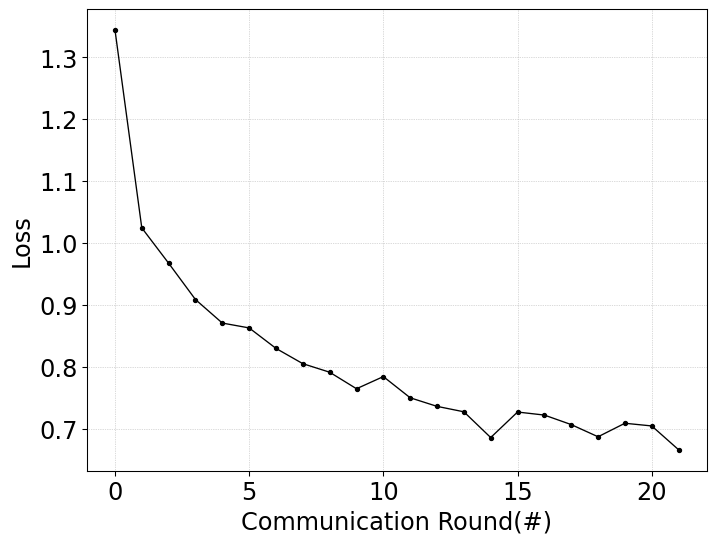

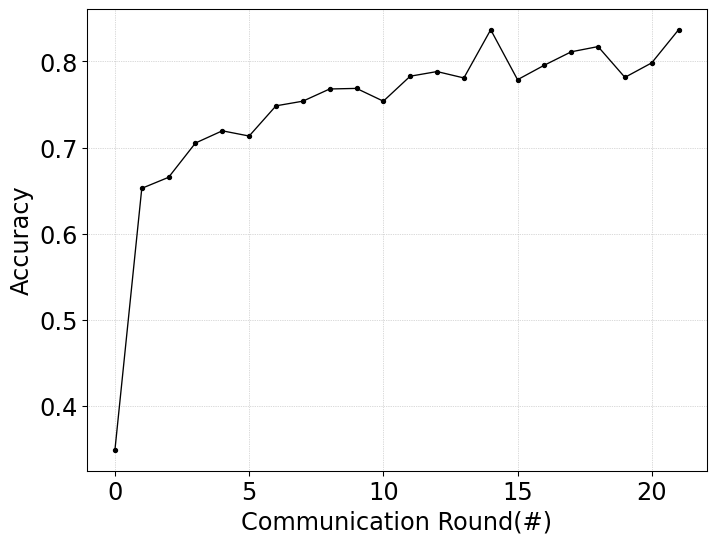

In [32]:
print("Output FL - Loss: ", history.losses_distributed)
print("Output FL - Accuracy: ", history.metrics_distributed)

print("Centralized metrics:", history.metrics_centralized)
print("Centralized losses:", history.losses_centralized)


fl_loss = []
fl_accuracy = []

for loss in history.losses_distributed:
  print(f"Loss in Round {loss[0]}: {loss[1]}")
  fl_loss.append(loss[1])

for accuracy in history.metrics_distributed["accuracy"]:
  print(f"Accuracy in Round {accuracy[0]}: {accuracy[1]}")
  fl_accuracy.append(accuracy[1])

communication_round = range(len(fl_loss))
my_dpi=96
plt.figure(figsize=(800/my_dpi, 600/my_dpi), dpi=my_dpi)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.plot(communication_round, fl_loss, linewidth=1, linestyle="solid", marker=".", color="black")
plt.xlabel("Communication Round(#)", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.grid(linestyle=':', linewidth='0.5')

############################################
communication_round = range(len(fl_accuracy))
my_dpi=96
plt.figure(figsize=(800/my_dpi, 600/my_dpi), dpi=my_dpi)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.plot(communication_round, fl_accuracy, linewidth=1, linestyle="solid", marker=".", color="black")
plt.xlabel("Communication Round(#)", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.grid(linestyle=':', linewidth='0.5')

# Server Test set Evaluation

In [33]:
# (ADJUSTMENTS)
import os
import torch

# ---------------------------------------------------------
# IDENTIFICAR MODELO GLOBAL (MELHOR ROUND)
# ---------------------------------------------------------

model_dir = "models_25_rounds"

# lista arquivos tipo model_roundX.pt
round_files = [f for f in os.listdir(model_dir) if f.startswith("model_round")]

if len(round_files) == 0:
    raise RuntimeError(f"Nenhum modelo encontrado em {model_dir}")

# extrai números dos rounds
round_numbers = sorted([
    int(f.replace("model_round", "").replace(".pt", ""))
    for f in round_files
])

# tenta usar o histórico do Flower para escolher melhor modelo
try:
    # history.losses_distributed = [(round, loss), ...]
    losses = history.losses_distributed
    best_round = min(losses, key=lambda x: x[1])[0]
except:
    # fallback: usa último round
    best_round = round_numbers[-1]

best_model_path = os.path.join(model_dir, f"model_round{best_round}.pt")
print(f"\n🔍 Carregando melhor modelo encontrado: Round {best_round}")
print(f"📁 Path: {best_model_path}")

# ---------------------------------------------------------
# CARREGAR O MODELO GLOBAL
# ---------------------------------------------------------

global_model = build_model(num_classes=NUM_CLASSES)
global_model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
global_model.to(DEVICE)
global_model.eval()

# ---------------------------------------------------------
# AVALIAÇÃO GLOBAL
# ---------------------------------------------------------

metrics, cm = evaluate(global_model, testloader, DEVICE, NUM_CLASSES)

print("\n📊 Métricas do Melhor Modelo Global:")
print(metrics)



🔍 Carregando melhor modelo encontrado: Round 22
📁 Path: models_25_rounds/model_round22.pt

📊 Métricas do Melhor Modelo Global:
{'loss': 1.2101079390968899, 'accuracy': 0.5719643694327239, 'precision': 0.5668504828855081, 'recall': 0.5719643694327239, 'f1-score': 0.569244448158092, 'auc': 0.7829919624215113}


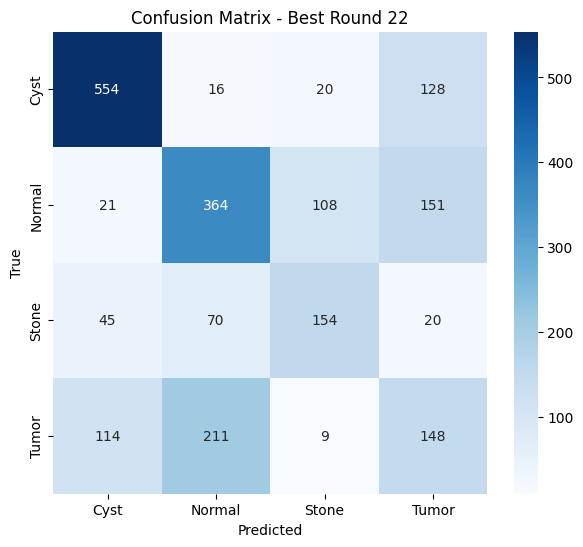

In [34]:
# (ADJUSTMENTS)
# ----------------------------
# CONFUSION MATRIX (BEST ROUND)
# ----------------------------

labels_map = {0: 'Cyst', 1: 'Normal', 2: 'Stone', 3: 'Tumor'}
labels = [labels_map[i] for i in range(len(labels_map))]

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.title(f"Confusion Matrix - Best Round {best_round}")
plt.xlabel("Predicted")
plt.ylabel("True")

# opcional: salva figura para relatório
plt.savefig(f"confusion_matrix_round_{best_round}.png", dpi=200, bbox_inches='tight')

plt.show()



In [35]:
# ----------------------------
# AVALIAÇÃO CENTRALIZADA FINAL
# ----------------------------

print("\n🔎 Avaliando o melhor modelo global no conjunto de TESTE...\n")

metrics, cm = evaluate(global_model, testloader, DEVICE, NUM_CLASSES)

print("📊 Resultados finais (Centralized Evaluation):")
print(f" - Loss:      {metrics['loss']:.6f}")
print(f" - Accuracy:  {metrics['accuracy']:.6f}")
print(f" - Precision: {metrics['precision']:.6f}")
print(f" - Recall:    {metrics['recall']:.6f}")
print(f" - F1-score:  {metrics['f1-score']:.6f}")
print(f" - AUC:       {metrics['auc']:.6f}")

# salva para logs
centralized_metrics = metrics



🔎 Avaliando o melhor modelo global no conjunto de TESTE...

📊 Resultados finais (Centralized Evaluation):
 - Loss:      1.205780
 - Accuracy:  0.564463
 - Precision: 0.561433
 - Recall:    0.564463
 - F1-score:  0.562843
 - AUC:       0.781892


(raylet) [2025-11-20 23:12:53,306 E 43649 43649] (raylet) node_manager.cc:3064: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 4a86bb5f5764153ba6182b01821967ced5efd28c0368d12ce50ca6b8, IP: 172.22.4.17) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.22.4.17`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(raylet) 
(raylet) [2025-11-20 23:16:53,309 E 43649 43649] (raylet) node_manager.cc:3064: 3 Workers (tasks / actors) ki